# Self‑Supervised Learning & Interactive Latent Space Visualization

This notebook demonstrates a self‑supervised workflow using a dataset of PNG images (organized by class). We:
- Load and split the data using stratification.
- Perform KMeans clustering on flattened images and evaluate with a confusion matrix.
- Train a simple convolutional autoencoder (with training/validation loss monitoring).
- Extract latent features and evaluate them using Logistic Regression and Random Forest.
- **Interactively explore the latent space:** Use the sliders below to choose which latent dimensions to plot in an Altair scatter plot.


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
from collections import Counter
from PIL import Image

# Set device (for simplicity, we'll use CPU)
device = torch.device("cpu")
print("Using device:", device)

/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/bin/../lib/libjpeg.9.dylib' (no such file)'If you don'

Using device: cpu


In [2]:
# Define transforms: resize images to 64x64 and convert to tensor.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Set the data directory. Each subfolder should correspond to one class.
data_dir = "./data/dataset"  
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Found classes:", dataset.classes)

# Get all indices and labels.
all_indices = np.arange(len(dataset))
all_labels = np.array(dataset.targets)

# Stratified split: 80% for train+val, 20% for test.
trainval_idx, test_idx = train_test_split(all_indices, test_size=0.2, stratify=all_labels, random_state=42)
# Split train+val into 90% train and 10% validation.
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.1, stratify=all_labels[trainval_idx], random_state=42)

print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_idx)}")
print(f"Validation images: {len(val_idx)}")
print(f"Test images: {len(test_idx)}")
print("Training label distribution:", Counter(all_labels[train_idx]))

# Create subsets and DataLoaders.
batch_size = 32
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Found classes: ['circles', 'hexagons', 'pentagons', 'quatrefoil', 'spikes', 'squares', 'triangles']
Total images: 2100
Training images: 1512
Validation images: 168
Test images: 420
Training label distribution: Counter({1: 216, 0: 216, 4: 216, 2: 216, 6: 216, 3: 216, 5: 216})


In [3]:
# Flatten every image in the full dataset and run KMeans clustering.
all_X = []
all_y = []
for img, label in dataset:
    all_X.append(img.view(-1).numpy())
    all_y.append(label)
all_X = np.array(all_X)
all_y = np.array(all_y)
print("Data shape (samples x features):", all_X.shape)

# Run KMeans clustering (without using labels).
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_X)

Data shape (samples x features): (2100, 12288)


KMeans Clustering Accuracy: 21.10%
KMeans Clustering F1 Score: 0.1997


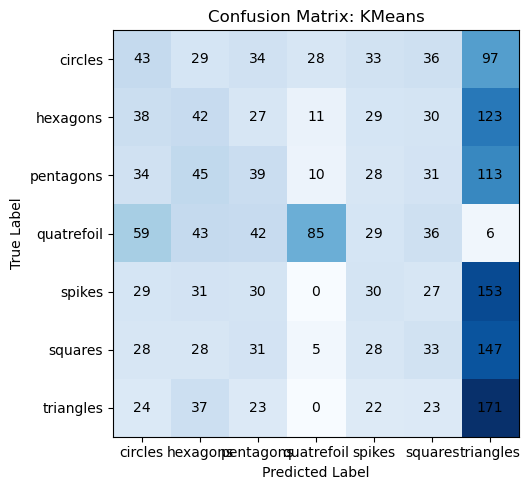

In [4]:
def map_cluster_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    new_preds = np.array([mapping[label] for label in y_pred])
    return new_preds, mapping

mapped_preds, mapping = map_cluster_labels(all_y, cluster_labels)

kmeans_acc = accuracy_score(all_y, mapped_preds) * 100
kmeans_f1 = f1_score(all_y, mapped_preds, average='macro')
print(f"KMeans Clustering Accuracy: {kmeans_acc:.2f}%")
print(f"KMeans Clustering F1 Score: {kmeans_f1:.4f}")

# Plot confusion matrix for KMeans.
cm_kmeans = confusion_matrix(all_y, mapped_preds)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_kmeans, cmap="Blues")
ax.set_title("Confusion Matrix: KMeans")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(len(dataset.classes)))
ax.set_yticks(np.arange(len(dataset.classes)))
ax.set_xticklabels(dataset.classes)
ax.set_yticklabels(dataset.classes)
for i in range(cm_kmeans.shape[0]):
    for j in range(cm_kmeans.shape[1]):
        ax.text(j, i, cm_kmeans[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()


In [5]:
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        # Encoder: Convolutional layers to extract features.
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # -> (16,32,32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32,16,16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (64,8,8)
            nn.ReLU(),
            nn.Flatten()
        )
        # The output from the conv block is 64*8*8.
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        
        # Decoder: Map latent vector back to image space.
        self.decoder_fc = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (32,16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16,32,32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (3,64,64)
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.decoder_fc(z)
        x_recon = self.decoder_conv(h_dec)
        return x_recon, mu, logvar
    
    def get_latent(self, x):
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        return mu

# Instantiate the VAE.
vae = VAE(latent_dim=32).to(device)


Epoch 1 Training: 100%|██████████| 48/48 [00:04<00:00,  9.97it/s, Beta=1e-10, ReconLoss=0.2051, KL_Loss=1151.3424, BatchLoss=0.2051]


Epoch 1: Train Loss = 0.2212, Val Loss = 0.1829


Epoch 2 Training: 100%|██████████| 48/48 [00:04<00:00, 10.15it/s, Beta=1e-10, ReconLoss=0.1184, KL_Loss=997.9675, BatchLoss=0.1184] 


Epoch 2: Train Loss = 0.1566, Val Loss = 0.1334


Epoch 3 Training: 100%|██████████| 48/48 [00:04<00:00, 10.46it/s, Beta=1e-10, ReconLoss=0.1263, KL_Loss=626.5101, BatchLoss=0.1263] 


Epoch 3: Train Loss = 0.1228, Val Loss = 0.1127


Epoch 4 Training: 100%|██████████| 48/48 [00:04<00:00, 10.50it/s, Beta=1e-10, ReconLoss=0.1093, KL_Loss=390.5352, BatchLoss=0.1093]


Epoch 4: Train Loss = 0.1032, Val Loss = 0.0943


Epoch 5 Training: 100%|██████████| 48/48 [00:04<00:00, 10.24it/s, Beta=1e-10, ReconLoss=0.0970, KL_Loss=1099.8395, BatchLoss=0.0970]


Epoch 5: Train Loss = 0.0914, Val Loss = 0.0868


Epoch 6 Training: 100%|██████████| 48/48 [00:04<00:00, 10.21it/s, Beta=1e-10, ReconLoss=0.0513, KL_Loss=4234.1582, BatchLoss=0.0513]


Epoch 6: Train Loss = 0.0848, Val Loss = 0.0822


Epoch 7 Training: 100%|██████████| 48/48 [00:04<00:00, 10.27it/s, Beta=1e-10, ReconLoss=0.0619, KL_Loss=10141.2490, BatchLoss=0.0619]


Epoch 7: Train Loss = 0.0813, Val Loss = 0.0807


Epoch 8 Training: 100%|██████████| 48/48 [00:04<00:00, 10.44it/s, Beta=1e-10, ReconLoss=0.0722, KL_Loss=4996.6973, BatchLoss=0.0722]


Epoch 8: Train Loss = 0.0796, Val Loss = 0.0793


Epoch 9 Training: 100%|██████████| 48/48 [00:04<00:00, 10.23it/s, Beta=1e-10, ReconLoss=0.0741, KL_Loss=12013.3057, BatchLoss=0.0741]


Epoch 9: Train Loss = 0.0777, Val Loss = 0.0765


Epoch 10 Training: 100%|██████████| 48/48 [00:04<00:00, 10.37it/s, Beta=1e-10, ReconLoss=0.0558, KL_Loss=14754.1973, BatchLoss=0.0558]


Epoch 10: Train Loss = 0.0736, Val Loss = 0.0698


Epoch 11 Training: 100%|██████████| 48/48 [00:04<00:00,  9.69it/s, Beta=1e-10, ReconLoss=0.0652, KL_Loss=4523.6899, BatchLoss=0.0652] 


Epoch 11: Train Loss = 0.0664, Val Loss = 0.0618


Epoch 12 Training: 100%|██████████| 48/48 [00:04<00:00, 10.20it/s, Beta=1e-10, ReconLoss=0.0458, KL_Loss=323.4905, BatchLoss=0.0458] 


Epoch 12: Train Loss = 0.0601, Val Loss = 0.0567


Epoch 13 Training: 100%|██████████| 48/48 [00:04<00:00, 10.42it/s, Beta=1e-10, ReconLoss=0.0462, KL_Loss=1575.3561, BatchLoss=0.0462]


Epoch 13: Train Loss = 0.0554, Val Loss = 0.0525


Epoch 14 Training: 100%|██████████| 48/48 [00:04<00:00, 10.41it/s, Beta=1e-10, ReconLoss=0.0491, KL_Loss=246.7344, BatchLoss=0.0491]


Epoch 14: Train Loss = 0.0514, Val Loss = 0.0491


Epoch 15 Training: 100%|██████████| 48/48 [00:04<00:00, 10.53it/s, Beta=1e-10, ReconLoss=0.0324, KL_Loss=326.3548, BatchLoss=0.0324]


Epoch 15: Train Loss = 0.0487, Val Loss = 0.0471


Epoch 16 Training: 100%|██████████| 48/48 [00:04<00:00, 10.00it/s, Beta=1e-10, ReconLoss=0.0317, KL_Loss=339.0824, BatchLoss=0.0317]


Epoch 16: Train Loss = 0.0469, Val Loss = 0.0457


Epoch 17 Training: 100%|██████████| 48/48 [00:04<00:00, 10.42it/s, Beta=1e-10, ReconLoss=0.0634, KL_Loss=311.4590, BatchLoss=0.0634]


Epoch 17: Train Loss = 0.0455, Val Loss = 0.0446


Epoch 18 Training: 100%|██████████| 48/48 [00:04<00:00, 10.42it/s, Beta=1e-10, ReconLoss=0.0477, KL_Loss=308.3503, BatchLoss=0.0477]


Epoch 18: Train Loss = 0.0444, Val Loss = 0.0437


Epoch 19 Training: 100%|██████████| 48/48 [00:04<00:00, 10.36it/s, Beta=1e-10, ReconLoss=0.0345, KL_Loss=310.0270, BatchLoss=0.0345]


Epoch 19: Train Loss = 0.0434, Val Loss = 0.0428


Epoch 20 Training: 100%|██████████| 48/48 [00:04<00:00, 10.46it/s, Beta=1e-10, ReconLoss=0.0348, KL_Loss=337.1523, BatchLoss=0.0348]


Epoch 20: Train Loss = 0.0424, Val Loss = 0.0420


Epoch 21 Training: 100%|██████████| 48/48 [00:04<00:00, 10.30it/s, Beta=1e-10, ReconLoss=0.0356, KL_Loss=367.3643, BatchLoss=0.0356]


Epoch 21: Train Loss = 0.0416, Val Loss = 0.0413


Epoch 22 Training: 100%|██████████| 48/48 [00:04<00:00, 10.41it/s, Beta=1e-10, ReconLoss=0.0419, KL_Loss=317.7748, BatchLoss=0.0419]


Epoch 22: Train Loss = 0.0408, Val Loss = 0.0405


Epoch 23 Training: 100%|██████████| 48/48 [00:04<00:00, 10.56it/s, Beta=1e-10, ReconLoss=0.0438, KL_Loss=402.7897, BatchLoss=0.0438]


Epoch 23: Train Loss = 0.0400, Val Loss = 0.0399


Epoch 24 Training: 100%|██████████| 48/48 [00:04<00:00, 10.58it/s, Beta=1e-10, ReconLoss=0.0390, KL_Loss=421.6095, BatchLoss=0.0390]


Epoch 24: Train Loss = 0.0394, Val Loss = 0.0392


Epoch 25 Training: 100%|██████████| 48/48 [00:04<00:00, 10.42it/s, Beta=1e-10, ReconLoss=0.0292, KL_Loss=373.7116, BatchLoss=0.0292]


Epoch 25: Train Loss = 0.0388, Val Loss = 0.0387


Epoch 26 Training: 100%|██████████| 48/48 [00:04<00:00, 10.34it/s, Beta=1e-10, ReconLoss=0.0457, KL_Loss=440.1781, BatchLoss=0.0457]


Epoch 26: Train Loss = 0.0382, Val Loss = 0.0381


Epoch 27 Training: 100%|██████████| 48/48 [00:05<00:00,  9.32it/s, Beta=1e-10, ReconLoss=0.0329, KL_Loss=467.3282, BatchLoss=0.0329]


Epoch 27: Train Loss = 0.0376, Val Loss = 0.0375


Epoch 28 Training: 100%|██████████| 48/48 [00:04<00:00, 10.28it/s, Beta=1e-10, ReconLoss=0.0391, KL_Loss=454.3983, BatchLoss=0.0391]


Epoch 28: Train Loss = 0.0368, Val Loss = 0.0362


Epoch 29 Training: 100%|██████████| 48/48 [00:04<00:00, 10.11it/s, Beta=1e-10, ReconLoss=0.0227, KL_Loss=512.1070, BatchLoss=0.0227]


Epoch 29: Train Loss = 0.0321, Val Loss = 0.0282


Epoch 30 Training: 100%|██████████| 48/48 [00:04<00:00, 10.25it/s, Beta=1e-10, ReconLoss=0.0185, KL_Loss=473.5368, BatchLoss=0.0185]


Epoch 30: Train Loss = 0.0249, Val Loss = 0.0235


Epoch 31 Training: 100%|██████████| 48/48 [00:04<00:00, 10.39it/s, Beta=1e-10, ReconLoss=0.0201, KL_Loss=582.7211, BatchLoss=0.0201]


Epoch 31: Train Loss = 0.0212, Val Loss = 0.0211


Epoch 32 Training: 100%|██████████| 48/48 [00:04<00:00, 10.18it/s, Beta=1e-10, ReconLoss=0.0153, KL_Loss=648.2613, BatchLoss=0.0153]


Epoch 32: Train Loss = 0.0194, Val Loss = 0.0197


Epoch 33 Training: 100%|██████████| 48/48 [00:04<00:00, 10.61it/s, Beta=1e-10, ReconLoss=0.0168, KL_Loss=597.4054, BatchLoss=0.0168]


Epoch 33: Train Loss = 0.0183, Val Loss = 0.0189


Epoch 34 Training: 100%|██████████| 48/48 [00:04<00:00, 10.15it/s, Beta=1e-10, ReconLoss=0.0146, KL_Loss=720.0829, BatchLoss=0.0146]


Epoch 34: Train Loss = 0.0176, Val Loss = 0.0182


Epoch 35 Training: 100%|██████████| 48/48 [00:04<00:00,  9.94it/s, Beta=1e-10, ReconLoss=0.0206, KL_Loss=726.0391, BatchLoss=0.0206]


Epoch 35: Train Loss = 0.0171, Val Loss = 0.0178


Epoch 36 Training: 100%|██████████| 48/48 [00:05<00:00,  9.23it/s, Beta=1e-10, ReconLoss=0.0142, KL_Loss=591.1151, BatchLoss=0.0142]


Epoch 36: Train Loss = 0.0166, Val Loss = 0.0174


Epoch 37 Training: 100%|██████████| 48/48 [00:04<00:00,  9.81it/s, Beta=1e-10, ReconLoss=0.0159, KL_Loss=839.5415, BatchLoss=0.0159]


Epoch 37: Train Loss = 0.0163, Val Loss = 0.0172


Epoch 38 Training: 100%|██████████| 48/48 [00:04<00:00, 10.40it/s, Beta=1e-10, ReconLoss=0.0153, KL_Loss=714.5583, BatchLoss=0.0153]


Epoch 38: Train Loss = 0.0160, Val Loss = 0.0169


Epoch 39 Training: 100%|██████████| 48/48 [00:04<00:00, 10.49it/s, Beta=1e-10, ReconLoss=0.0168, KL_Loss=750.4102, BatchLoss=0.0168]


Epoch 39: Train Loss = 0.0157, Val Loss = 0.0166


Epoch 40 Training: 100%|██████████| 48/48 [00:04<00:00, 10.52it/s, Beta=1e-10, ReconLoss=0.0139, KL_Loss=704.8331, BatchLoss=0.0139]


Epoch 40: Train Loss = 0.0154, Val Loss = 0.0164


Epoch 41 Training: 100%|██████████| 48/48 [00:04<00:00, 10.28it/s, Beta=1e-10, ReconLoss=0.0130, KL_Loss=694.1619, BatchLoss=0.0130]


Epoch 41: Train Loss = 0.0152, Val Loss = 0.0162


Epoch 42 Training: 100%|██████████| 48/48 [00:04<00:00, 10.67it/s, Beta=1e-10, ReconLoss=0.0102, KL_Loss=611.7759, BatchLoss=0.0102]


Epoch 42: Train Loss = 0.0150, Val Loss = 0.0160


Epoch 43 Training: 100%|██████████| 48/48 [00:04<00:00, 10.57it/s, Beta=1e-10, ReconLoss=0.0183, KL_Loss=717.5607, BatchLoss=0.0183]


Epoch 43: Train Loss = 0.0148, Val Loss = 0.0158


Epoch 44 Training: 100%|██████████| 48/48 [00:04<00:00, 10.38it/s, Beta=1e-10, ReconLoss=0.0172, KL_Loss=647.2611, BatchLoss=0.0172]


Epoch 44: Train Loss = 0.0146, Val Loss = 0.0156


Epoch 45 Training: 100%|██████████| 48/48 [00:04<00:00, 10.36it/s, Beta=1e-10, ReconLoss=0.0182, KL_Loss=750.6944, BatchLoss=0.0182]


Epoch 45: Train Loss = 0.0144, Val Loss = 0.0154


Epoch 46 Training: 100%|██████████| 48/48 [00:04<00:00, 10.42it/s, Beta=1e-10, ReconLoss=0.0132, KL_Loss=624.5768, BatchLoss=0.0132]


Epoch 46: Train Loss = 0.0143, Val Loss = 0.0153


Epoch 47 Training: 100%|██████████| 48/48 [00:04<00:00, 10.00it/s, Beta=1e-10, ReconLoss=0.0112, KL_Loss=619.9177, BatchLoss=0.0112]


Epoch 47: Train Loss = 0.0141, Val Loss = 0.0152


Epoch 48 Training: 100%|██████████| 48/48 [00:04<00:00, 10.50it/s, Beta=1e-10, ReconLoss=0.0137, KL_Loss=917.1921, BatchLoss=0.0137]


Epoch 48: Train Loss = 0.0140, Val Loss = 0.0150


Epoch 49 Training: 100%|██████████| 48/48 [00:04<00:00, 10.25it/s, Beta=1e-10, ReconLoss=0.0137, KL_Loss=609.5921, BatchLoss=0.0137]


Epoch 49: Train Loss = 0.0138, Val Loss = 0.0149


Epoch 50 Training: 100%|██████████| 48/48 [00:04<00:00, 10.45it/s, Beta=1e-10, ReconLoss=0.0141, KL_Loss=702.0321, BatchLoss=0.0141]


Epoch 50: Train Loss = 0.0137, Val Loss = 0.0148


Epoch 51 Training: 100%|██████████| 48/48 [00:04<00:00, 10.48it/s, Beta=1e-10, ReconLoss=0.0134, KL_Loss=654.3632, BatchLoss=0.0134]


Epoch 51: Train Loss = 0.0135, Val Loss = 0.0146


Epoch 52 Training: 100%|██████████| 48/48 [00:04<00:00, 10.55it/s, Beta=1e-10, ReconLoss=0.0130, KL_Loss=780.0709, BatchLoss=0.0130]


Epoch 52: Train Loss = 0.0134, Val Loss = 0.0146


Epoch 53 Training: 100%|██████████| 48/48 [00:04<00:00, 10.43it/s, Beta=1e-10, ReconLoss=0.0130, KL_Loss=862.0499, BatchLoss=0.0130]


Epoch 53: Train Loss = 0.0133, Val Loss = 0.0145


Epoch 54 Training: 100%|██████████| 48/48 [00:04<00:00, 10.46it/s, Beta=1e-10, ReconLoss=0.0124, KL_Loss=854.8774, BatchLoss=0.0124]


Epoch 54: Train Loss = 0.0132, Val Loss = 0.0144


Epoch 55 Training: 100%|██████████| 48/48 [00:04<00:00, 10.59it/s, Beta=1e-10, ReconLoss=0.0152, KL_Loss=877.4044, BatchLoss=0.0152]


Epoch 55: Train Loss = 0.0130, Val Loss = 0.0143


Epoch 56 Training: 100%|██████████| 48/48 [00:04<00:00, 10.44it/s, Beta=1e-10, ReconLoss=0.0131, KL_Loss=921.3105, BatchLoss=0.0131]


Epoch 56: Train Loss = 0.0129, Val Loss = 0.0142


Epoch 57 Training: 100%|██████████| 48/48 [00:04<00:00, 10.55it/s, Beta=1e-10, ReconLoss=0.0139, KL_Loss=702.2427, BatchLoss=0.0139]


Epoch 57: Train Loss = 0.0128, Val Loss = 0.0141


Epoch 58 Training: 100%|██████████| 48/48 [00:04<00:00, 10.44it/s, Beta=1e-10, ReconLoss=0.0100, KL_Loss=616.1122, BatchLoss=0.0100]


Epoch 58: Train Loss = 0.0127, Val Loss = 0.0140


Epoch 59 Training: 100%|██████████| 48/48 [00:04<00:00, 10.36it/s, Beta=1e-10, ReconLoss=0.0125, KL_Loss=791.9133, BatchLoss=0.0125]


Epoch 59: Train Loss = 0.0126, Val Loss = 0.0139


Epoch 60 Training: 100%|██████████| 48/48 [00:04<00:00, 10.45it/s, Beta=1e-10, ReconLoss=0.0163, KL_Loss=948.2043, BatchLoss=0.0163]


Epoch 60: Train Loss = 0.0125, Val Loss = 0.0138


Epoch 61 Training: 100%|██████████| 48/48 [00:04<00:00, 10.61it/s, Beta=1e-10, ReconLoss=0.0163, KL_Loss=834.0972, BatchLoss=0.0163]


Epoch 61: Train Loss = 0.0124, Val Loss = 0.0138


Epoch 62 Training: 100%|██████████| 48/48 [00:04<00:00, 10.51it/s, Beta=1e-10, ReconLoss=0.0082, KL_Loss=496.4321, BatchLoss=0.0082]


Epoch 62: Train Loss = 0.0123, Val Loss = 0.0137


Epoch 63 Training: 100%|██████████| 48/48 [00:04<00:00, 10.39it/s, Beta=1e-10, ReconLoss=0.0130, KL_Loss=728.6722, BatchLoss=0.0130]


Epoch 63: Train Loss = 0.0122, Val Loss = 0.0137


Epoch 64 Training: 100%|██████████| 48/48 [00:04<00:00, 10.59it/s, Beta=1e-10, ReconLoss=0.0179, KL_Loss=814.3730, BatchLoss=0.0179]


Epoch 64: Train Loss = 0.0121, Val Loss = 0.0136


Epoch 65 Training: 100%|██████████| 48/48 [00:04<00:00, 10.32it/s, Beta=1e-10, ReconLoss=0.0114, KL_Loss=652.1959, BatchLoss=0.0114]


Epoch 65: Train Loss = 0.0120, Val Loss = 0.0135


Epoch 66 Training: 100%|██████████| 48/48 [00:04<00:00, 10.27it/s, Beta=1e-10, ReconLoss=0.0184, KL_Loss=904.5980, BatchLoss=0.0184]


Epoch 66: Train Loss = 0.0119, Val Loss = 0.0134


Epoch 67 Training: 100%|██████████| 48/48 [00:04<00:00,  9.75it/s, Beta=1e-10, ReconLoss=0.0090, KL_Loss=592.7416, BatchLoss=0.0090]


Epoch 67: Train Loss = 0.0118, Val Loss = 0.0134


Epoch 68 Training: 100%|██████████| 48/48 [00:04<00:00,  9.93it/s, Beta=1e-10, ReconLoss=0.0137, KL_Loss=868.9088, BatchLoss=0.0137]


Epoch 68: Train Loss = 0.0117, Val Loss = 0.0133


Epoch 69 Training: 100%|██████████| 48/48 [00:05<00:00,  9.07it/s, Beta=1e-10, ReconLoss=0.0123, KL_Loss=845.6404, BatchLoss=0.0123]


Epoch 69: Train Loss = 0.0117, Val Loss = 0.0132


Epoch 70 Training: 100%|██████████| 48/48 [00:04<00:00, 10.23it/s, Beta=1e-10, ReconLoss=0.0153, KL_Loss=844.4223, BatchLoss=0.0153]


Epoch 70: Train Loss = 0.0116, Val Loss = 0.0132


Epoch 71 Training: 100%|██████████| 48/48 [00:04<00:00,  9.62it/s, Beta=1e-10, ReconLoss=0.0097, KL_Loss=895.5488, BatchLoss=0.0097]


Epoch 71: Train Loss = 0.0115, Val Loss = 0.0131


Epoch 72 Training: 100%|██████████| 48/48 [00:04<00:00, 10.10it/s, Beta=1e-10, ReconLoss=0.0166, KL_Loss=773.3882, BatchLoss=0.0166]


Epoch 72: Train Loss = 0.0114, Val Loss = 0.0131


Epoch 73 Training: 100%|██████████| 48/48 [00:04<00:00,  9.95it/s, Beta=1e-10, ReconLoss=0.0128, KL_Loss=771.3748, BatchLoss=0.0128]


Epoch 73: Train Loss = 0.0113, Val Loss = 0.0130


Epoch 74 Training: 100%|██████████| 48/48 [00:05<00:00,  9.58it/s, Beta=1e-10, ReconLoss=0.0130, KL_Loss=877.1974, BatchLoss=0.0130]


Epoch 74: Train Loss = 0.0113, Val Loss = 0.0130


Epoch 75 Training: 100%|██████████| 48/48 [00:04<00:00, 10.11it/s, Beta=1e-10, ReconLoss=0.0131, KL_Loss=928.5613, BatchLoss=0.0131]


Epoch 75: Train Loss = 0.0112, Val Loss = 0.0129


Epoch 76 Training: 100%|██████████| 48/48 [00:05<00:00,  9.18it/s, Beta=1e-10, ReconLoss=0.0151, KL_Loss=935.0352, BatchLoss=0.0151]


Epoch 76: Train Loss = 0.0111, Val Loss = 0.0129


Epoch 77 Training: 100%|██████████| 48/48 [00:05<00:00,  8.56it/s, Beta=1e-10, ReconLoss=0.0077, KL_Loss=771.8493, BatchLoss=0.0077]


Epoch 77: Train Loss = 0.0111, Val Loss = 0.0129


Epoch 78 Training: 100%|██████████| 48/48 [00:08<00:00,  5.58it/s, Beta=1e-10, ReconLoss=0.0099, KL_Loss=653.1031, BatchLoss=0.0099]


Epoch 78: Train Loss = 0.0110, Val Loss = 0.0128


Epoch 79 Training: 100%|██████████| 48/48 [00:08<00:00,  5.82it/s, Beta=1e-10, ReconLoss=0.0120, KL_Loss=978.3594, BatchLoss=0.0120]


Epoch 79: Train Loss = 0.0109, Val Loss = 0.0128


Epoch 80 Training: 100%|██████████| 48/48 [00:07<00:00,  6.81it/s, Beta=1e-10, ReconLoss=0.0097, KL_Loss=850.6111, BatchLoss=0.0097]


Epoch 80: Train Loss = 0.0109, Val Loss = 0.0127


Epoch 81 Training: 100%|██████████| 48/48 [00:07<00:00,  6.48it/s, Beta=1e-10, ReconLoss=0.0101, KL_Loss=785.4627, BatchLoss=0.0101]


Epoch 81: Train Loss = 0.0108, Val Loss = 0.0127


Epoch 82 Training: 100%|██████████| 48/48 [00:05<00:00,  9.05it/s, Beta=1e-10, ReconLoss=0.0113, KL_Loss=819.3885, BatchLoss=0.0113]


Epoch 82: Train Loss = 0.0108, Val Loss = 0.0126


Epoch 83 Training: 100%|██████████| 48/48 [00:05<00:00,  8.94it/s, Beta=1e-10, ReconLoss=0.0094, KL_Loss=568.6439, BatchLoss=0.0094]


Epoch 83: Train Loss = 0.0107, Val Loss = 0.0126


Epoch 84 Training: 100%|██████████| 48/48 [00:05<00:00,  9.56it/s, Beta=1e-10, ReconLoss=0.0160, KL_Loss=817.0921, BatchLoss=0.0160]


Epoch 84: Train Loss = 0.0106, Val Loss = 0.0126


Epoch 85 Training: 100%|██████████| 48/48 [00:05<00:00,  8.70it/s, Beta=1e-10, ReconLoss=0.0138, KL_Loss=765.3590, BatchLoss=0.0138]


Epoch 85: Train Loss = 0.0106, Val Loss = 0.0125


Epoch 86 Training: 100%|██████████| 48/48 [00:05<00:00,  8.70it/s, Beta=1e-10, ReconLoss=0.0085, KL_Loss=666.8743, BatchLoss=0.0085] 


Epoch 86: Train Loss = 0.0105, Val Loss = 0.0125


Epoch 87 Training: 100%|██████████| 48/48 [00:05<00:00,  8.69it/s, Beta=1e-10, ReconLoss=0.0122, KL_Loss=851.1542, BatchLoss=0.0122]


Epoch 87: Train Loss = 0.0105, Val Loss = 0.0125


Epoch 88 Training: 100%|██████████| 48/48 [00:05<00:00,  9.04it/s, Beta=1e-10, ReconLoss=0.0142, KL_Loss=979.0560, BatchLoss=0.0142]


Epoch 88: Train Loss = 0.0104, Val Loss = 0.0125


Epoch 89 Training: 100%|██████████| 48/48 [00:04<00:00,  9.68it/s, Beta=1e-10, ReconLoss=0.0073, KL_Loss=841.6299, BatchLoss=0.0073]


Epoch 89: Train Loss = 0.0104, Val Loss = 0.0124


Epoch 90 Training: 100%|██████████| 48/48 [00:05<00:00,  9.36it/s, Beta=1e-10, ReconLoss=0.0082, KL_Loss=831.8054, BatchLoss=0.0082] 


Epoch 90: Train Loss = 0.0103, Val Loss = 0.0124


Epoch 91 Training: 100%|██████████| 48/48 [00:04<00:00,  9.66it/s, Beta=1e-10, ReconLoss=0.0133, KL_Loss=789.6082, BatchLoss=0.0133]


Epoch 91: Train Loss = 0.0102, Val Loss = 0.0123


Epoch 92 Training: 100%|██████████| 48/48 [00:05<00:00,  9.28it/s, Beta=1e-10, ReconLoss=0.0095, KL_Loss=858.5161, BatchLoss=0.0095]


Epoch 92: Train Loss = 0.0102, Val Loss = 0.0123


Epoch 93 Training: 100%|██████████| 48/48 [00:05<00:00,  9.41it/s, Beta=1e-10, ReconLoss=0.0111, KL_Loss=1108.4113, BatchLoss=0.0111]


Epoch 93: Train Loss = 0.0101, Val Loss = 0.0122


Epoch 94 Training: 100%|██████████| 48/48 [00:05<00:00,  9.38it/s, Beta=1e-10, ReconLoss=0.0159, KL_Loss=851.9545, BatchLoss=0.0159]


Epoch 94: Train Loss = 0.0101, Val Loss = 0.0123


Epoch 95 Training: 100%|██████████| 48/48 [00:04<00:00,  9.61it/s, Beta=1e-10, ReconLoss=0.0113, KL_Loss=993.7054, BatchLoss=0.0113]


Epoch 95: Train Loss = 0.0101, Val Loss = 0.0122


Epoch 96 Training: 100%|██████████| 48/48 [00:05<00:00,  9.52it/s, Beta=1e-10, ReconLoss=0.0083, KL_Loss=795.3954, BatchLoss=0.0083]


Epoch 96: Train Loss = 0.0100, Val Loss = 0.0122


Epoch 97 Training: 100%|██████████| 48/48 [00:05<00:00,  9.55it/s, Beta=1e-10, ReconLoss=0.0101, KL_Loss=923.9368, BatchLoss=0.0101] 


Epoch 97: Train Loss = 0.0099, Val Loss = 0.0121


Epoch 98 Training: 100%|██████████| 48/48 [00:05<00:00,  9.49it/s, Beta=1e-10, ReconLoss=0.0057, KL_Loss=938.5919, BatchLoss=0.0057]


Epoch 98: Train Loss = 0.0099, Val Loss = 0.0121


Epoch 99 Training: 100%|██████████| 48/48 [00:04<00:00,  9.78it/s, Beta=1e-10, ReconLoss=0.0070, KL_Loss=885.4437, BatchLoss=0.0070]


Epoch 99: Train Loss = 0.0098, Val Loss = 0.0121


Epoch 100 Training: 100%|██████████| 48/48 [00:04<00:00,  9.74it/s, Beta=1e-10, ReconLoss=0.0099, KL_Loss=1070.2371, BatchLoss=0.0099]


Epoch 100: Train Loss = 0.0098, Val Loss = 0.0120


Epoch 101 Training: 100%|██████████| 48/48 [00:05<00:00,  9.03it/s, Beta=1e-10, ReconLoss=0.0095, KL_Loss=840.0151, BatchLoss=0.0095] 


Epoch 101: Train Loss = 0.0098, Val Loss = 0.0120


Epoch 102 Training: 100%|██████████| 48/48 [00:05<00:00,  9.48it/s, Beta=1e-10, ReconLoss=0.0106, KL_Loss=989.4696, BatchLoss=0.0106] 


Epoch 102: Train Loss = 0.0097, Val Loss = 0.0120


Epoch 103 Training: 100%|██████████| 48/48 [00:04<00:00, 10.77it/s, Beta=1e-10, ReconLoss=0.0101, KL_Loss=609.6833, BatchLoss=0.0101]


Epoch 103: Train Loss = 0.0097, Val Loss = 0.0120


Epoch 104 Training: 100%|██████████| 48/48 [00:04<00:00, 10.24it/s, Beta=1e-10, ReconLoss=0.0098, KL_Loss=803.9452, BatchLoss=0.0098] 


Epoch 104: Train Loss = 0.0096, Val Loss = 0.0120


Epoch 105 Training: 100%|██████████| 48/48 [00:04<00:00, 10.52it/s, Beta=1e-10, ReconLoss=0.0081, KL_Loss=731.4805, BatchLoss=0.0081] 


Epoch 105: Train Loss = 0.0096, Val Loss = 0.0119


Epoch 106 Training: 100%|██████████| 48/48 [00:04<00:00, 10.57it/s, Beta=1e-10, ReconLoss=0.0096, KL_Loss=741.9126, BatchLoss=0.0096] 


Epoch 106: Train Loss = 0.0095, Val Loss = 0.0119


Epoch 107 Training: 100%|██████████| 48/48 [00:04<00:00, 10.18it/s, Beta=1e-10, ReconLoss=0.0081, KL_Loss=914.7714, BatchLoss=0.0081]


Epoch 107: Train Loss = 0.0095, Val Loss = 0.0119


Epoch 108 Training: 100%|██████████| 48/48 [00:04<00:00, 10.47it/s, Beta=1e-10, ReconLoss=0.0104, KL_Loss=908.1673, BatchLoss=0.0104] 


Epoch 108: Train Loss = 0.0094, Val Loss = 0.0119


Epoch 109 Training: 100%|██████████| 48/48 [00:04<00:00, 10.52it/s, Beta=1e-10, ReconLoss=0.0090, KL_Loss=761.5352, BatchLoss=0.0090] 


Epoch 109: Train Loss = 0.0094, Val Loss = 0.0118


Epoch 110 Training: 100%|██████████| 48/48 [00:04<00:00, 10.44it/s, Beta=1e-10, ReconLoss=0.0095, KL_Loss=814.9218, BatchLoss=0.0095] 


Epoch 110: Train Loss = 0.0094, Val Loss = 0.0119


Epoch 111 Training: 100%|██████████| 48/48 [00:04<00:00, 10.44it/s, Beta=1e-10, ReconLoss=0.0088, KL_Loss=937.8932, BatchLoss=0.0088] 


Epoch 111: Train Loss = 0.0093, Val Loss = 0.0118


Epoch 112 Training: 100%|██████████| 48/48 [00:04<00:00,  9.92it/s, Beta=1e-10, ReconLoss=0.0115, KL_Loss=940.5235, BatchLoss=0.0115] 


Epoch 112: Train Loss = 0.0093, Val Loss = 0.0118


Epoch 113 Training: 100%|██████████| 48/48 [00:04<00:00, 10.43it/s, Beta=1e-10, ReconLoss=0.0098, KL_Loss=882.5210, BatchLoss=0.0098] 


Epoch 113: Train Loss = 0.0092, Val Loss = 0.0118


Epoch 114 Training: 100%|██████████| 48/48 [00:04<00:00, 10.36it/s, Beta=1e-10, ReconLoss=0.0154, KL_Loss=865.9113, BatchLoss=0.0154] 


Epoch 114: Train Loss = 0.0092, Val Loss = 0.0117


Epoch 115 Training: 100%|██████████| 48/48 [00:04<00:00, 10.20it/s, Beta=1e-10, ReconLoss=0.0083, KL_Loss=945.0514, BatchLoss=0.0083] 


Epoch 115: Train Loss = 0.0092, Val Loss = 0.0117


Epoch 116 Training: 100%|██████████| 48/48 [00:04<00:00, 10.38it/s, Beta=1e-10, ReconLoss=0.0087, KL_Loss=725.4760, BatchLoss=0.0087] 


Epoch 116: Train Loss = 0.0091, Val Loss = 0.0117


Epoch 117 Training: 100%|██████████| 48/48 [00:04<00:00, 10.45it/s, Beta=1e-10, ReconLoss=0.0108, KL_Loss=778.7701, BatchLoss=0.0108] 


Epoch 117: Train Loss = 0.0091, Val Loss = 0.0117


Epoch 118 Training: 100%|██████████| 48/48 [00:04<00:00, 10.51it/s, Beta=1e-10, ReconLoss=0.0095, KL_Loss=865.7775, BatchLoss=0.0095] 


Epoch 118: Train Loss = 0.0091, Val Loss = 0.0117


Epoch 119 Training: 100%|██████████| 48/48 [00:04<00:00, 10.43it/s, Beta=1e-10, ReconLoss=0.0045, KL_Loss=856.9322, BatchLoss=0.0045] 


Epoch 119: Train Loss = 0.0090, Val Loss = 0.0116


Epoch 120 Training: 100%|██████████| 48/48 [00:04<00:00, 10.36it/s, Beta=1e-10, ReconLoss=0.0083, KL_Loss=914.3804, BatchLoss=0.0083] 


Epoch 120: Train Loss = 0.0090, Val Loss = 0.0116


Epoch 121 Training: 100%|██████████| 48/48 [00:04<00:00, 10.53it/s, Beta=1e-10, ReconLoss=0.0088, KL_Loss=967.4681, BatchLoss=0.0088] 


Epoch 121: Train Loss = 0.0089, Val Loss = 0.0116


Epoch 122 Training: 100%|██████████| 48/48 [00:04<00:00, 10.50it/s, Beta=1e-10, ReconLoss=0.0097, KL_Loss=909.6598, BatchLoss=0.0097] 


Epoch 122: Train Loss = 0.0089, Val Loss = 0.0116


Epoch 123 Training: 100%|██████████| 48/48 [00:04<00:00,  9.83it/s, Beta=1e-10, ReconLoss=0.0093, KL_Loss=874.3411, BatchLoss=0.0093] 


Epoch 123: Train Loss = 0.0089, Val Loss = 0.0116


Epoch 124 Training: 100%|██████████| 48/48 [00:05<00:00,  9.24it/s, Beta=1e-10, ReconLoss=0.0067, KL_Loss=677.3099, BatchLoss=0.0067] 


Epoch 124: Train Loss = 0.0088, Val Loss = 0.0116


Epoch 125 Training: 100%|██████████| 48/48 [00:04<00:00,  9.62it/s, Beta=1e-10, ReconLoss=0.0137, KL_Loss=1168.1903, BatchLoss=0.0137]


Epoch 125: Train Loss = 0.0088, Val Loss = 0.0115


Epoch 126 Training: 100%|██████████| 48/48 [00:05<00:00,  9.48it/s, Beta=1e-10, ReconLoss=0.0081, KL_Loss=739.1731, BatchLoss=0.0081] 


Epoch 126: Train Loss = 0.0088, Val Loss = 0.0116


Epoch 127 Training: 100%|██████████| 48/48 [00:05<00:00,  8.52it/s, Beta=1e-10, ReconLoss=0.0083, KL_Loss=792.3452, BatchLoss=0.0083] 


Epoch 127: Train Loss = 0.0087, Val Loss = 0.0115


Epoch 128 Training: 100%|██████████| 48/48 [00:05<00:00,  9.58it/s, Beta=1e-10, ReconLoss=0.0100, KL_Loss=997.1100, BatchLoss=0.0100] 


Epoch 128: Train Loss = 0.0087, Val Loss = 0.0115


Epoch 129 Training: 100%|██████████| 48/48 [00:05<00:00,  9.56it/s, Beta=1e-10, ReconLoss=0.0053, KL_Loss=1058.4133, BatchLoss=0.0053]


Epoch 129: Train Loss = 0.0087, Val Loss = 0.0114


Epoch 130 Training: 100%|██████████| 48/48 [00:04<00:00,  9.76it/s, Beta=1e-10, ReconLoss=0.0071, KL_Loss=1017.7351, BatchLoss=0.0071]


Epoch 130: Train Loss = 0.0086, Val Loss = 0.0114


Epoch 131 Training: 100%|██████████| 48/48 [00:05<00:00,  9.31it/s, Beta=1e-10, ReconLoss=0.0114, KL_Loss=1144.9062, BatchLoss=0.0114]


Epoch 131: Train Loss = 0.0086, Val Loss = 0.0114


Epoch 132 Training: 100%|██████████| 48/48 [00:04<00:00,  9.70it/s, Beta=1e-10, ReconLoss=0.0062, KL_Loss=782.8539, BatchLoss=0.0062] 


Epoch 132: Train Loss = 0.0085, Val Loss = 0.0114


Epoch 133 Training: 100%|██████████| 48/48 [00:04<00:00,  9.69it/s, Beta=1e-10, ReconLoss=0.0062, KL_Loss=864.0519, BatchLoss=0.0062] 


Epoch 133: Train Loss = 0.0085, Val Loss = 0.0114


Epoch 134 Training: 100%|██████████| 48/48 [00:05<00:00,  9.57it/s, Beta=1e-10, ReconLoss=0.0059, KL_Loss=925.1270, BatchLoss=0.0059] 


Epoch 134: Train Loss = 0.0085, Val Loss = 0.0113


Epoch 135 Training: 100%|██████████| 48/48 [00:05<00:00,  9.59it/s, Beta=1e-10, ReconLoss=0.0046, KL_Loss=746.7473, BatchLoss=0.0046] 


Epoch 135: Train Loss = 0.0084, Val Loss = 0.0113


Epoch 136 Training: 100%|██████████| 48/48 [00:05<00:00,  9.42it/s, Beta=1e-10, ReconLoss=0.0083, KL_Loss=911.2924, BatchLoss=0.0083] 


Epoch 136: Train Loss = 0.0084, Val Loss = 0.0113


Epoch 137 Training: 100%|██████████| 48/48 [00:05<00:00,  9.04it/s, Beta=1e-10, ReconLoss=0.0094, KL_Loss=764.0367, BatchLoss=0.0094] 


Epoch 137: Train Loss = 0.0084, Val Loss = 0.0113


Epoch 138 Training: 100%|██████████| 48/48 [00:04<00:00,  9.92it/s, Beta=1e-10, ReconLoss=0.0087, KL_Loss=973.9727, BatchLoss=0.0087] 


Epoch 138: Train Loss = 0.0083, Val Loss = 0.0113


Epoch 139 Training: 100%|██████████| 48/48 [00:04<00:00, 10.32it/s, Beta=1e-10, ReconLoss=0.0058, KL_Loss=789.0152, BatchLoss=0.0058] 


Epoch 139: Train Loss = 0.0083, Val Loss = 0.0113


Epoch 140 Training: 100%|██████████| 48/48 [00:05<00:00,  8.92it/s, Beta=1e-10, ReconLoss=0.0097, KL_Loss=764.2560, BatchLoss=0.0097] 


Epoch 140: Train Loss = 0.0083, Val Loss = 0.0113


Epoch 141 Training: 100%|██████████| 48/48 [00:04<00:00,  9.80it/s, Beta=1e-10, ReconLoss=0.0086, KL_Loss=848.3383, BatchLoss=0.0086] 


Epoch 141: Train Loss = 0.0082, Val Loss = 0.0113


Epoch 142 Training: 100%|██████████| 48/48 [00:04<00:00, 10.17it/s, Beta=1e-10, ReconLoss=0.0105, KL_Loss=982.4234, BatchLoss=0.0105] 


Epoch 142: Train Loss = 0.0082, Val Loss = 0.0113


Epoch 143 Training: 100%|██████████| 48/48 [00:04<00:00, 10.30it/s, Beta=1e-10, ReconLoss=0.0076, KL_Loss=927.2830, BatchLoss=0.0076] 


Epoch 143: Train Loss = 0.0082, Val Loss = 0.0112


Epoch 144 Training: 100%|██████████| 48/48 [00:04<00:00,  9.91it/s, Beta=1e-10, ReconLoss=0.0066, KL_Loss=1035.1350, BatchLoss=0.0066]


Epoch 144: Train Loss = 0.0081, Val Loss = 0.0112


Epoch 145 Training: 100%|██████████| 48/48 [00:04<00:00, 10.56it/s, Beta=1e-10, ReconLoss=0.0065, KL_Loss=1107.0177, BatchLoss=0.0065]


Epoch 145: Train Loss = 0.0081, Val Loss = 0.0112


Epoch 146 Training: 100%|██████████| 48/48 [00:04<00:00, 10.34it/s, Beta=1e-10, ReconLoss=0.0069, KL_Loss=1160.5681, BatchLoss=0.0069]


Epoch 146: Train Loss = 0.0081, Val Loss = 0.0112


Epoch 147 Training: 100%|██████████| 48/48 [00:04<00:00, 10.27it/s, Beta=1e-10, ReconLoss=0.0124, KL_Loss=1336.0603, BatchLoss=0.0124]


Epoch 147: Train Loss = 0.0081, Val Loss = 0.0111


Epoch 148 Training: 100%|██████████| 48/48 [00:04<00:00, 10.10it/s, Beta=1e-10, ReconLoss=0.0072, KL_Loss=1039.1602, BatchLoss=0.0072]


Epoch 148: Train Loss = 0.0080, Val Loss = 0.0111


Epoch 149 Training: 100%|██████████| 48/48 [00:04<00:00, 10.34it/s, Beta=1e-10, ReconLoss=0.0077, KL_Loss=870.1792, BatchLoss=0.0077] 


Epoch 149: Train Loss = 0.0080, Val Loss = 0.0111


Epoch 150 Training: 100%|██████████| 48/48 [00:04<00:00, 10.19it/s, Beta=1e-10, ReconLoss=0.0069, KL_Loss=1237.6581, BatchLoss=0.0069]


Epoch 150: Train Loss = 0.0080, Val Loss = 0.0111


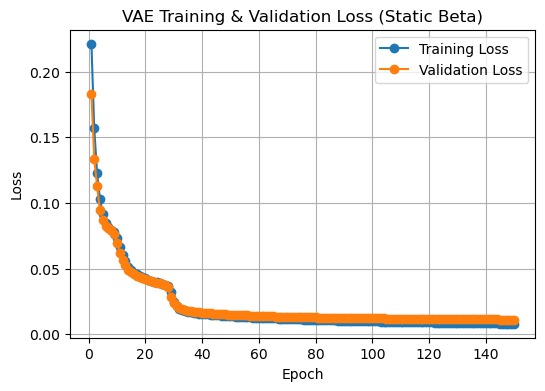

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set a constant beta value for the KL divergence.
beta = 0.0000000001  # Adjust this value as needed.

vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# Use mean reduction so that the reconstruction loss is averaged over all pixels.
recon_criterion = nn.MSELoss(reduction='mean')
n_epochs = 50  # Adjust as needed.
train_losses = []
val_losses = []

def kl_divergence(mu, logvar):
    # Compute KL divergence (averaged over the batch)
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def plot_reconstructions(loader, phase="Training"):
    """
    Pull a single batch from the given loader, compute reconstructions,
    and display original and reconstructed images side by side.
    """
    vae.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        recon, _, _ = vae(imgs)
    imgs = imgs.cpu()
    recon = recon.cpu()
    n = min(8, imgs.size(0))  # Show up to 8 images.
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        # Convert tensor images from C x H x W to H x W x C for plotting.
        axes[0, i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original", fontsize=8)
        axes[1, i].imshow(np.transpose(recon[i].numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstruction", fontsize=8)
    fig.suptitle(f"{phase} Reconstructions")
    plt.tight_layout()
    plt.show()

for epoch in range(n_epochs):
    vae.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        recon_loss = recon_criterion(recon, imgs)
        kl_loss = kl_divergence(mu, logvar)
        loss = recon_loss + beta * kl_loss  # Total loss.
        loss.backward()
        vae_optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({
            "Beta": beta,
            "ReconLoss": f"{recon_loss.item():.4f}",
            "KL_Loss": f"{kl_loss.item():.4f}",
            "BatchLoss": f"{loss.item():.4f}"
        })
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    vae.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            recon, mu, logvar = vae(imgs)
            recon_loss = recon_criterion(recon, imgs)
            kl_loss = kl_divergence(mu, logvar)
            loss = recon_loss + beta * kl_loss
            running_val += loss.item() * imgs.size(0)
    val_loss = running_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    # Plot reconstructions for a batch from training and validation sets.
    plot_reconstructions(train_loader, phase="Training")
    plot_reconstructions(val_loader, phase="Validation")
    
plt.figure(figsize=(6,4))
epochs_range = np.arange(1, n_epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label="Training Loss")
plt.plot(epochs_range, val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training & Validation Loss (Static Beta)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Extract latent features from the test set.
vae.eval()
all_latents = []
all_labels = []
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        latent = vae.get_latent(imgs)
    all_latents.append(latent.cpu().numpy())
    all_labels.extend(labels.numpy())
test_latents = np.concatenate(all_latents, axis=0)
test_labels = np.array(all_labels)
print("Extracted latent features shape:", test_latents.shape)

# Also extract file paths for the test images.
# 'test_dataset' is a Subset of the full dataset.
test_img_paths = []
for i in range(len(test_dataset)):
    idx = test_dataset.indices[i]  # get the corresponding index in the full dataset
    test_img_paths.append(dataset.imgs[idx][0])
print("Number of test image paths:", len(test_img_paths))

# Save latent features, labels, and file paths in a tuple for later use.
latent_data = (test_latents, test_labels, test_img_paths)

Extracted latent features shape: (420, 32)
Number of test image paths: 420


/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 42.14%, F1 Score = 0.4161
Random Forest: Accuracy = 100.00%, F1 Score = 1.0000


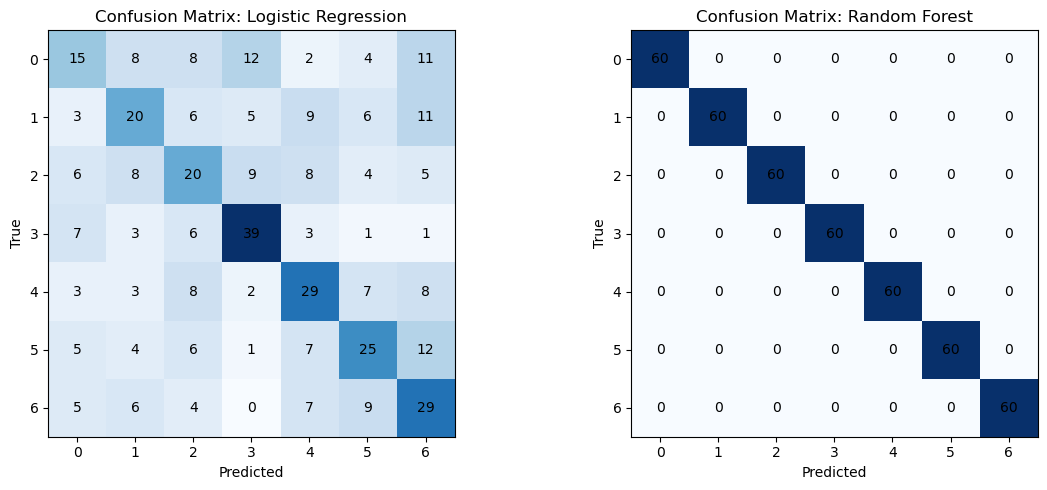

In [13]:
# For demonstration, we use the test set for both training and evaluation.
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(test_latents, test_labels)
lr_preds = lr_clf.predict(test_latents)
lr_acc = accuracy_score(test_labels, lr_preds) * 100
lr_f1 = f1_score(test_labels, lr_preds, average='macro')

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(test_latents, test_labels)
rf_preds = rf_clf.predict(test_latents)
rf_acc = accuracy_score(test_labels, rf_preds) * 100
rf_f1 = f1_score(test_labels, rf_preds, average='macro')

print(f"Logistic Regression: Accuracy = {lr_acc:.2f}%, F1 Score = {lr_f1:.4f}")
print(f"Random Forest: Accuracy = {rf_acc:.2f}%, F1 Score = {rf_f1:.4f}")

# Plot confusion matrices.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_lr = confusion_matrix(test_labels, lr_preds)
axs[0].imshow(cm_lr, cmap="Blues")
axs[0].set_title("Confusion Matrix: Logistic Regression")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")
axs[0].set_xticks(np.arange(len(np.unique(test_labels))))
axs[0].set_yticks(np.arange(len(np.unique(test_labels))))
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        axs[0].text(j, i, cm_lr[i,j], ha="center", va="center", color="black")

cm_rf = confusion_matrix(test_labels, rf_preds)
axs[1].imshow(cm_rf, cmap="Blues")
axs[1].set_title("Confusion Matrix: Random Forest")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
axs[1].set_xticks(np.arange(len(np.unique(test_labels))))
axs[1].set_yticks(np.arange(len(np.unique(test_labels))))
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        axs[1].text(j, i, cm_rf[i,j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

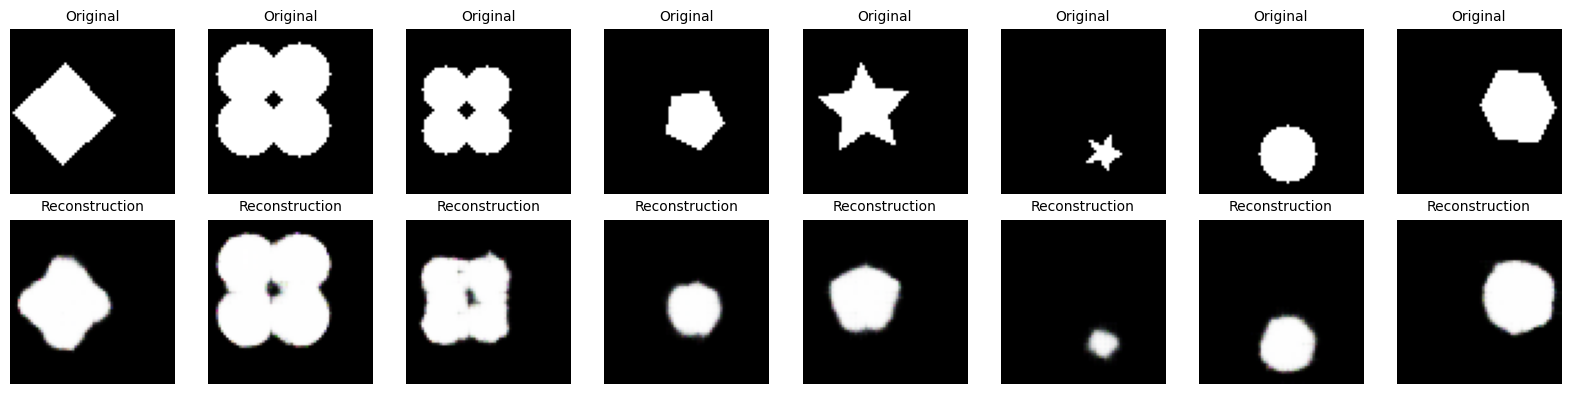

In [14]:
# Cell: Reconstruct and Plot Images from Latent Space

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Get a batch of test images.
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

vae.eval()
with torch.no_grad():
    # Get the latent representation (we use the mean from the encoder).
    latent = vae.get_latent(images)
    # Decode: Pass latent through the decoder.
    h_dec = vae.decoder_fc(latent)
    reconstructions = vae.decoder_conv(h_dec)

# Move images to CPU.
images = images.cpu()
reconstructions = reconstructions.cpu()

# Convert tensors to PIL images for visualization.
to_pil = ToPILImage()

n = min(8, images.size(0))  # number of images to display
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
for i in range(n):
    axes[0, i].imshow(to_pil(images[i]))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original", fontsize=10)
    
    axes[1, i].imshow(to_pil(reconstructions[i]))
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstruction", fontsize=10)

plt.tight_layout()
plt.show()

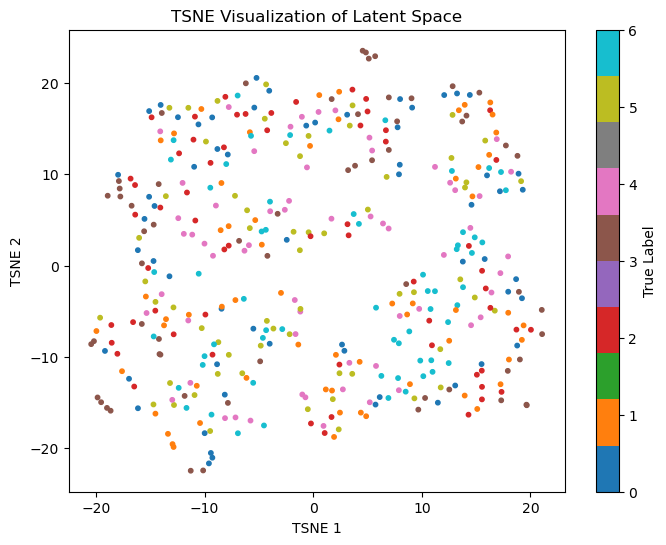

In [15]:
from sklearn.manifold import TSNE

# Assuming test_latents and test_labels have been defined in a previous cell.
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(test_latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=test_labels, cmap='tab10', s=10)
plt.title("TSNE Visualization of Latent Space")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.colorbar(scatter, label="True Label")
plt.show()

In [11]:
# Ensure latent_data is available.
test_latents, test_labels, test_img_paths = latent_data

# Create interactive widgets for selecting latent dimensions.
x_slider = widgets.IntSlider(value=0, min=0, max=test_latents.shape[1]-1, description='X Dim:')
y_slider = widgets.IntSlider(value=1, min=0, max=test_latents.shape[1]-1, description='Y Dim:')

# Create a dropdown widget to select a sample.
options = {}
for i, lbl in enumerate(test_labels):
    class_name = dataset.classes[lbl]
    options[f"Index {i} - {class_name}"] = i
sample_dropdown = widgets.Dropdown(options=options, description="Select sample:")

def update_visualization(x_index, y_index, sample_index):
    # Create a DataFrame for the scatter plot.
    df = pd.DataFrame({
        "x": test_latents[:, x_index],
        "y": test_latents[:, y_index],
        "label": test_labels.astype(str)
    })
    chart = alt.Chart(df).mark_circle(size=60).encode(
        x=alt.X("x", title=f"Latent Dimension {x_index}"),
        y=alt.Y("y", title=f"Latent Dimension {y_index}"),
        color=alt.Color("label:N", scale=alt.Scale(scheme="tableau10"), legend=alt.Legend(title="True Label")),
        tooltip=["x", "y", "label"]
    ).properties(
        width=500,
        height=400,
        title="Interactive Latent Space Visualization"
    )
    clear_output(wait=True)
    display(widgets.HBox([x_slider, y_slider, sample_dropdown]))
    display(chart)
    
    # Load and display the corresponding image.
    selected_path = test_img_paths[sample_index]
    try:
        img = Image.open(selected_path)
        print(f"Displaying image for sample index {sample_index}:")
        display(img)
    except Exception as e:
        print(f"Error loading image: {e}")

# Tie the widgets to the update function.
out = widgets.interactive_output(update_visualization, {'x_index': x_slider, 'y_index': y_slider, 'sample_index': sample_dropdown})
display(widgets.HBox([x_slider, y_slider, sample_dropdown]))
display(out)


Output()